---

Skeleton points passing it through SAM 

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import SamPredictor, sam_model_registry


In [2]:
file_no = 130

In [3]:
rgb_image_path = f"../../Complete_Data/xArm/Final_RGB/{file_no}.png"
mask_image_path = f"../../Complete_Data/xArm/Final_Mask/{file_no}.png"

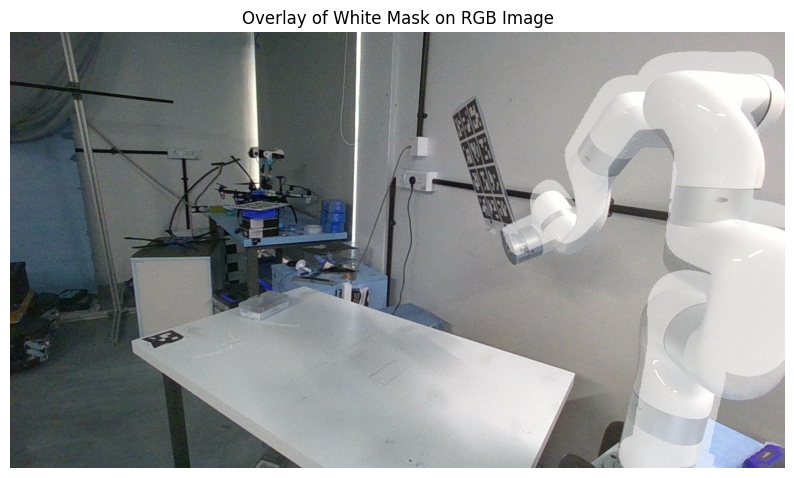

In [4]:
rgb_image = cv2.imread(rgb_image_path)
mask_image = cv2.imread(mask_image_path, cv2.IMREAD_GRAYSCALE)  
binary_mask = cv2.inRange(mask_image, 255, 255) 

binary_mask_resized = cv2.resize(binary_mask, (rgb_image.shape[1], rgb_image.shape[0]))

mask_rgb = np.stack([binary_mask_resized] * 3, axis=-1)

alpha = 0.5

rgb_image_overlay = np.where(mask_rgb == 255,
                             rgb_image * (1 - alpha) + mask_rgb * alpha,  
                             rgb_image) 

rgb_image_overlay_rgb = cv2.cvtColor(rgb_image_overlay.astype(np.uint8), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(rgb_image_overlay_rgb)
plt.title("Overlay of White Mask on RGB Image")
plt.axis("off")
plt.show()


(-0.5, 1279.5, 719.5, -0.5)

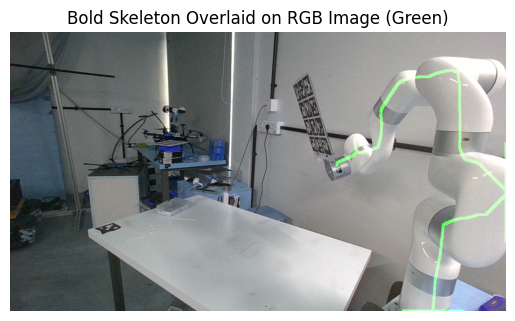

In [5]:

rgb_image = cv2.imread(rgb_image_path)
mask_image = cv2.imread(mask_image_path, cv2.IMREAD_GRAYSCALE)

_, binary_mask = cv2.threshold(mask_image, 50, 255, cv2.THRESH_BINARY)

skeleton = cv2.ximgproc.thinning(binary_mask)

bold_skeleton = cv2.dilate(skeleton, np.ones((3, 3), np.uint8), iterations=3)

# Create a green image where the bold skeleton is
green_skeleton = np.zeros_like(rgb_image)
green_skeleton[bold_skeleton == 255] = [0, 255, 0]  # Green color (BGR format)

# Combine the skeleton with the original image
overlay_rgb_skeleton = cv2.addWeighted(rgb_image, 1, green_skeleton, 1, 0)

plt.imshow(cv2.cvtColor(overlay_rgb_skeleton, cv2.COLOR_BGR2RGB))
plt.title("Bold Skeleton Overlaid on RGB Image (Green)")
plt.axis("off")


In [6]:

skeleton_points = np.column_stack(np.where(bold_skeleton > 0))

# print("Skeleton Points:")
# for point in skeleton_points:
#     print(f"x: {point[1]}, y: {point[0]}")


In [7]:
sam_checkpoint = "./segment-anything/sam_vit_h_4b8939.pth"
model_type = "vit_h"  
device = "cuda"  
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)
predictor = SamPredictor(sam)


/home/aniruth/Desktop/RRC/XARM7/xArm-Python-SDK/example/wrapper/xarm7/Follow_DROID/Franka_arm/SAM/segment-anything/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this e

In [8]:
skeleton_points

array([[  73, 1201],
       [  73, 1202],
       [  73, 1203],
       ...,
       [ 719, 1167],
       [ 719, 1168],
       [ 719, 1169]])

In [9]:
input_points = np.array([[point[1], point[0]] for point in skeleton_points])  # Convert to (x, y) format
input_labels = np.ones(input_points.shape[0])  # Label as foreground points (1 for SAM)


In [10]:
input_points

array([[1201,   73],
       [1202,   73],
       [1203,   73],
       ...,
       [1167,  719],
       [1168,  719],
       [1169,  719]])

In [11]:
num_space = 700 # instead of taking all the 12k points , choose spacing  between the points

In [12]:
len(input_points)/num_space

17.964285714285715

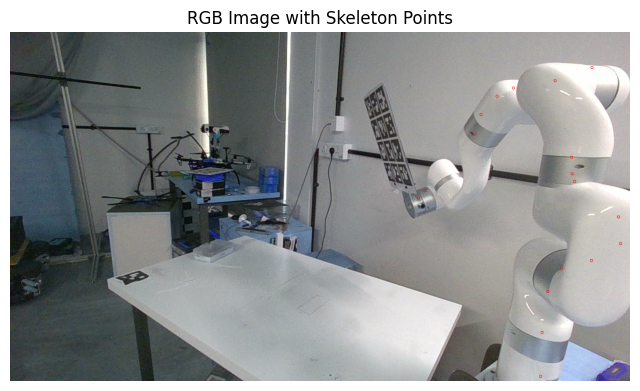

In [13]:
rgb_image = cv2.imread(rgb_image_path)

for point in input_points[::num_space]:
    cv2.circle(rgb_image, (point[0], point[1]), radius=3, color=(0, 0, 255), thickness=1)

rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 8))
plt.imshow(rgb_image)

plt.title("RGB Image with Skeleton Points")
plt.axis("off")
plt.show()


In [14]:
predictor.set_image(rgb_image)

masks, _, _ = predictor.predict(
    point_coords=input_points[::num_space],
    point_labels=input_labels[::num_space],
    multimask_output=False,  # Use a single mask for simplicity
)

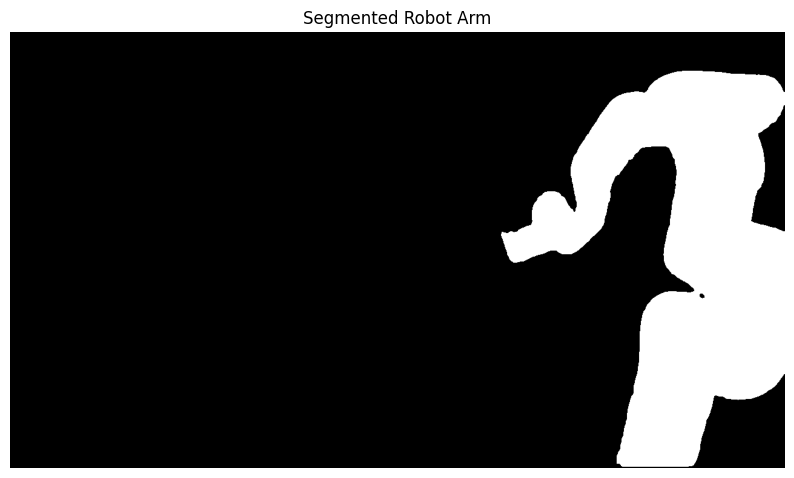

In [15]:
segmented_mask = masks[0] 

plt.figure(figsize=(10, 10))
plt.imshow(segmented_mask, cmap='gray') 
plt.title("Segmented Robot Arm")
plt.axis("off")
plt.show()


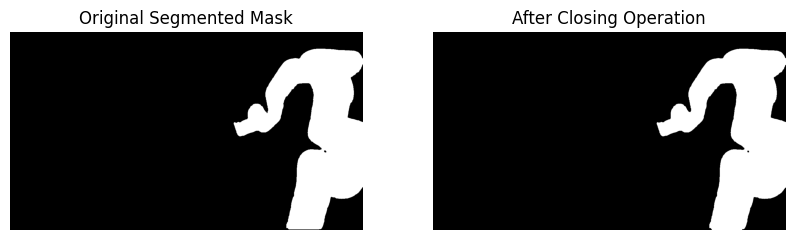

In [16]:
"""
This cell performs closing operation to fill up the holes !!
"""

segmented_mask_uint8 = (segmented_mask * 255).astype(np.uint8) if segmented_mask.max() == 1 else segmented_mask.astype(np.uint8)

kernel = np.ones((5, 5), np.uint8)  # A 5x5 square kernel

closed_mask = cv2.morphologyEx(segmented_mask_uint8, cv2.MORPH_CLOSE, kernel)

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(segmented_mask_uint8, cmap='gray')
plt.title("Original Segmented Mask")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(closed_mask, cmap='gray')
plt.title("After Closing Operation")
plt.axis("off")

plt.show()


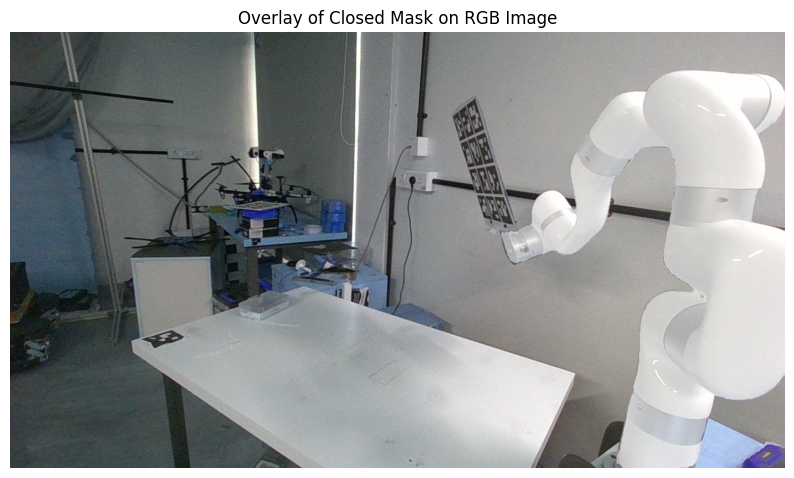

In [17]:


rgb_image = cv2.imread(rgb_image_path)

closed_mask_resized = cv2.resize(closed_mask, (rgb_image.shape[1], rgb_image.shape[0]))

mask_rgb = np.stack([closed_mask_resized] * 3, axis=-1)

alpha = 0.5

rgb_image_overlay = np.where(mask_rgb == 255,
                             rgb_image * (1 - alpha) + mask_rgb * alpha,  
                             rgb_image)

rgb_image_overlay_rgb_sam = cv2.cvtColor(rgb_image_overlay.astype(np.uint8), cv2.COLOR_BGR2RGB)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(rgb_image_overlay_rgb_sam)
plt.title("Overlay of Closed Mask on RGB Image")
plt.axis("off")
plt.show()



In [18]:

rgb_image = cv2.imread(rgb_image_path)
mask_image = cv2.imread(mask_image_path, cv2.IMREAD_GRAYSCALE)  
binary_mask = cv2.inRange(mask_image, 255, 255) 

binary_mask_resized = cv2.resize(binary_mask, (rgb_image.shape[1], rgb_image.shape[0]))

mask_rgb = np.stack([binary_mask_resized] * 3, axis=-1)

alpha = 0.5

rgb_image_overlay = np.where(mask_rgb == 255,
                             rgb_image * (1 - alpha) + mask_rgb * alpha,  
                             rgb_image) 

rgb_image_overlay_rgb = cv2.cvtColor(rgb_image_overlay.astype(np.uint8), cv2.COLOR_BGR2RGB)



In [19]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(rgb_image_overlay_rgb)
plt.title("Overlay of Current Mask after calibration ")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(rgb_image_overlay_rgb_sam)
plt.title("Overlay of Fine tuned mask ")
plt.axis("off")f

plt.tight_layout()
plt.show()

SyntaxError: invalid syntax (885495049.py, line 11)